# Drift Tubes Digi Occupancy Anomaly Problem with Autoencoders

#### Objective
This exercise examines if there is more information about anomalies in occupancy data. Autoencoder is going to be stacked on top of the CNN model to spot strange unusual occupancy plots.

In [1]:
import math
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use("ggplot")

from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, AveragePooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model, load_model
from keras import backend as K

Using TensorFlow backend.


## Data preparation and analysis

First, let's load occupancy data to the dataframe, we are going to train on 39 runs and test on only one.

In [2]:
runs = [273158, 273730, 274388, 274422, 274968, 274969, 275310, 275311,
        275847, 275890, 276244, 276283, 276384, 276587, 276775, 276776,
        276950, 278509, 278820, 278822, 279694, 279766, 279794, 280018,
        281693, 281727, 281976, 282735, 282814, 276582, 272011, 272012,
        272014, 272017, 272021, 272774, 284044, 284043, 284042, 284041]

test_run = [284041]
train_runs = [r for r in runs if r not in test_run]

drift_tubes_layers = pd.DataFrame()

for run in runs:
    path = "../data/%s.json" % run
    drift_tubes_layers = drift_tubes_layers.append(pd.read_json(path),
                                                   ignore_index=True);

In [3]:
drift_tubes_layers["content"] = drift_tubes_layers["content"].apply(eval)

We have to smooth occupancy since there is some amount of cells reporting extreme values. This will affect scaling, autoencoder bahavior and eventually the results. We will apply median polling of size 3.

In [4]:
SMOOTH_FILTER_SIZE = 3

def smooth_occupancy(layer):
    """Smooths layer occupancy using median filter"""
    smooth_layer = []
    for index in range(len(layer) - (SMOOTH_FILTER_SIZE-1)):
        median = np.median(layer[ index : index + SMOOTH_FILTER_SIZE ])
        smooth_layer.append(median)
    return np.array(smooth_layer)

drift_tubes_layers["content_smoothed"] = drift_tubes_layers["content"].apply(smooth_occupancy)

Now, the layers are different sizes, let's reshape them to equal sizes using mean polling. We need to end up with a sample as vector of size 47. Since the window can't be a float, we will apply this slicing: [round_down(step), round_up(step)].

In [5]:
LAYER_TARGET_SIZE = 47

def reshape_occupancy(layer):
    """Reshapes layer occupancy to the target size"""
    reshaped_layer = []
    step = len(layer) / float(LAYER_TARGET_SIZE)
    stop = 0
    for _ in range(LAYER_TARGET_SIZE):
        hook = math.floor(stop)
        stop = step + stop
        mean = np.mean(layer[int(hook) : int(math.ceil(stop))])
        reshaped_layer.append(mean)
    return np.array(reshaped_layer)

drift_tubes_layers["content_reshaped"] = drift_tubes_layers["content_smoothed"].apply(reshape_occupancy)

Let's evaluate if the layer is faulty using trained CNN model.

In [6]:
CNN_MODEL = load_model("../model_keras/model.h5")

def scale_occupancy(layer):
    """Scales the layer to the <0, 1> range"""
    denominator = np.max(layer)
    if denominator:
        return layer / denominator
    return layer

def score_occupancy(layer):
    """Predicts if layer is faulty or good"""
    layer = scale_occupancy(layer)
    return np.argmax(CNN_MODEL.predict(layer.reshape(-1, 47)))

drift_tubes_layers["score"] = drift_tubes_layers["content_reshaped"].apply(score_occupancy)

We scale the hits, so that all occupancies stay in 0 to 1 range within a run. This way ratios between the chamber occupancies are still there.

In [7]:
def get_occypancy_histogram(values, bins):
    """Plots the distribution of hits"""
    plt.hist(np.array(values).flatten(), bins)
    plt.title("Distribution of number of hits per cell", fontsize=10)
    plt.xlabel("Hits per cell", fontsize=8)
    plt.ylabel("Number of cells", fontsize=8)
    plt.yscale("log", nonposy="clip")
    plt.show();

In [8]:
def max_in_run(content):
    """Looks for maximum value for each run"""
    helper = {}
    for run in runs:
        values_per_run = drift_tubes_layers[drift_tubes_layers.run == run][content].values
        helper[run] = np.amax(np.vstack(np.array(values_per_run)))
    return helper

def scale_layer(hits_array, scaler):
    """Sales hits by scaler"""
    return [hit / scaler for hit in hits_array]

def scale_dataset(new_column, old_column):
    """Scales the dataset"""
    helper = max_in_run(old_column)
    drift_tubes_layers[new_column] = drift_tubes_layers.apply(lambda row: scale_layer(row[old_column], helper[row["run"]]), axis=1)

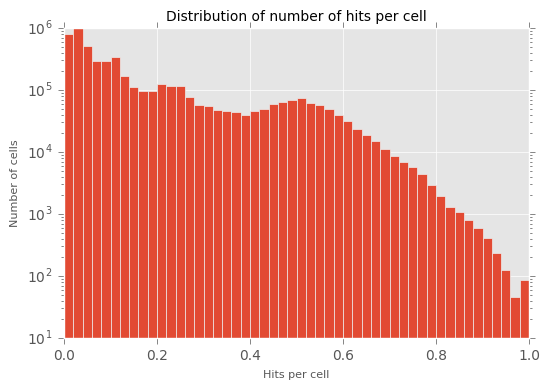

In [9]:
scale_dataset("content_scaled", "content_reshaped")
get_occypancy_histogram(drift_tubes_layers["content_scaled"].values.tolist(), 50)

The zipf distribution of hits will influance our metrics for detecting anomalies. To account for this, let's change the distribution to more gaussian.

In [10]:
def change_distribution(x):
    """Changes distribution of x"""
    return np.power(np.array(x).flatten(), 0.35)

drift_tubes_layers['content_powered'] = drift_tubes_layers['content_reshaped'].apply(change_distribution)

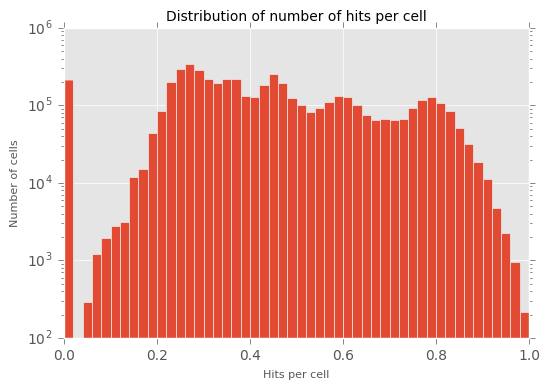

In [11]:
scale_dataset("content_powered_scaled", "content_powered")
get_occypancy_histogram(drift_tubes_layers["content_powered_scaled"].values.tolist(), 50)

Finally, let's combine per layer data so we have a matrix of size 12x47 corresponding to a chamber data

In [12]:
drift_tubes_chambers = pd.DataFrame()

for run in runs:
    for wheel in range(-2, 3):
        for station in range(1, 5):
            for sector in range(1, 15):

                chamber = drift_tubes_layers[(drift_tubes_layers.run == run) &
                                             (drift_tubes_layers.wheel == wheel) &
                                             (drift_tubes_layers.station == station) &
                                             (drift_tubes_layers.sector == sector)].sort_values('layer',
                                                                                                ascending=1)
                if len(chamber):
                    occupancy_powered_scaled = [_ for _ in chamber['content_powered_scaled']]
                    occupancy_scaled = [_ for _ in chamber['content_scaled']]
                    occupancy_reshaped = [_ for _ in chamber['content_reshaped']]
                    occupancy_smoothed = [_.tolist() for _ in chamber["content_smoothed"]]
                    occupancy_raw = [_ for _ in chamber["content"]]

                    extended_size_smoothed = max((len(_) for _ in occupancy_smoothed))
                    extended_size_raw = max((len(_) for _ in occupancy_raw))

                    for index, layer in enumerate(occupancy_raw):
                        layer.extend([np.nan]*(extended_size_raw-len(layer)))
                        occupancy_raw[index] = layer

                    for index, layer in enumerate(occupancy_smoothed):
                        layer.extend([np.nan]*(extended_size_smoothed-len(layer)))
                        occupancy_smoothed[index] = layer
                        
                    score = sum(chamber.score.values)
                    
                    data = {'run': run,
                            'wheel': wheel,
                            'station': station,
                            'sector': sector,
                            'score': score,
                            'content_powered_scaled': np.reshape(occupancy_powered_scaled, (len(chamber), 47)),
                            'content_scaled': np.reshape(occupancy_scaled, (len(chamber), 47)),
                            'content_reshaped': np.reshape(occupancy_reshaped, (len(chamber), 47)),
                            'content_smoothed': np.reshape(occupancy_smoothed, (len(chamber), extended_size_smoothed)),
                            'content_raw': np.reshape(occupancy_raw, (len(chamber), extended_size_raw))}

                    drift_tubes_chambers = drift_tubes_chambers.append(pd.Series(data), ignore_index=True)

### Visualizing processing pipeline

Here are some examples of one chamber (sample) on every step of data preparation:

In [13]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_occupancy_hitmap(data, title):
    plt.figure()
    ax = plt.gca()
    
    plt.xlabel("Channel", fontsize=8)
    plt.ylabel("Layer", fontsize=8)
    im = ax.imshow(data, interpolation="nearest")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax, ticks=[np.min(np.nan_to_num(data)), np.max(np.nan_to_num(data))])
    plt.title(title, loc='right', fontsize=10)
    plt.show();

def visualize_preprocessing(show):
    plot_occupancy_hitmap(show.content_raw,
                          "Raw Occupancy (Run: %s, W: %s, St: %s, Sec: %s)" % 
                          (show.run, show.wheel, show.station, show.sector))

    plot_occupancy_hitmap(show.content_smoothed,
                          "Smoothed Occupancy (Run: %s, W: %s, St: %s, Sec: %s)" % 
                          (show.run, show.wheel, show.station, show.sector))
    
    plot_occupancy_hitmap(show.content_reshaped,
                          "Reshaped Occupancy (Run: %s, W: %s, St: %s, Sec: %s)" % 
                          (show.run, show.wheel, show.station, show.sector))

    plot_occupancy_hitmap(show.content_scaled,
                          "Scaled Occupancy (Run: %s, W: %s, St: %s, Sec: %s)" % 
                          (show.run, show.wheel, show.station, show.sector))

    plot_occupancy_hitmap(show.content_powered_scaled,
                          "Powered Occupancy (Run: %s, W: %s, St: %s, Sec: %s)" % 
                          (show.run, show.wheel, show.station, show.sector))

#### Chamber with no problems

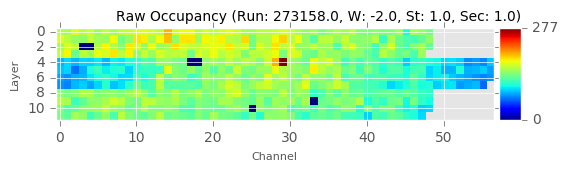

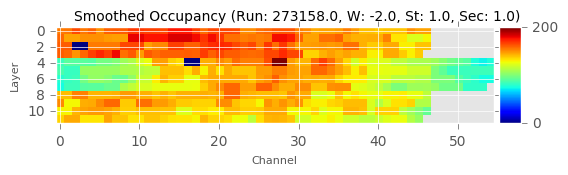

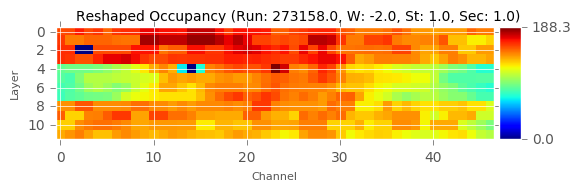

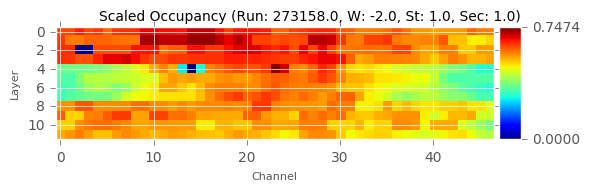

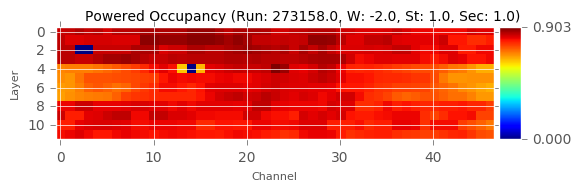

In [14]:
visualize_preprocessing(drift_tubes_chambers[drift_tubes_chambers.score == 0].iloc[0])

#### Chamber with one faulty layer

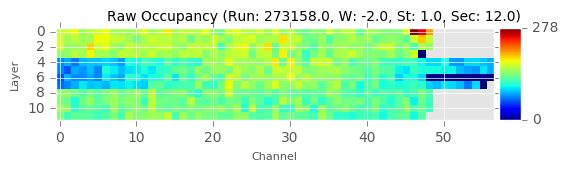

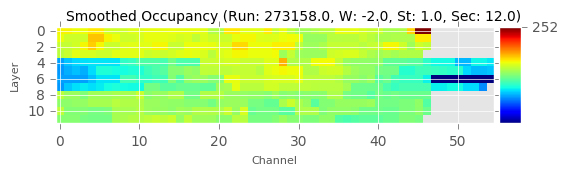

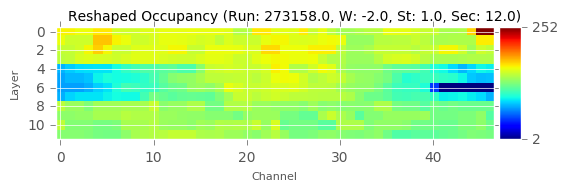

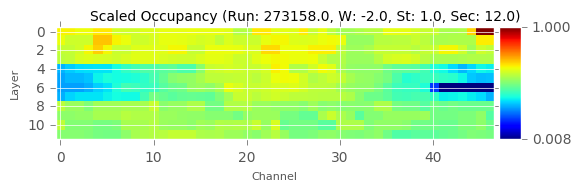

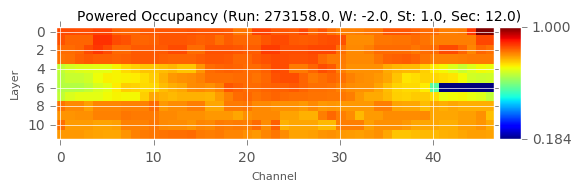

In [15]:
visualize_preprocessing(drift_tubes_chambers[drift_tubes_chambers.score == 1].iloc[0])

#### Chamber with one faulty superlayer (4 layers)

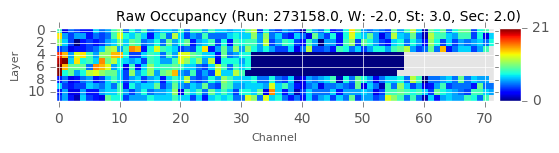

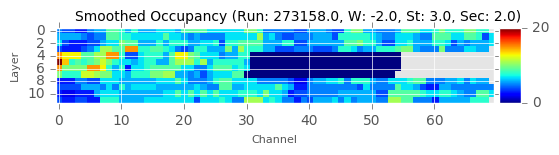

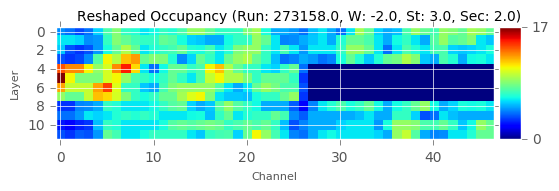

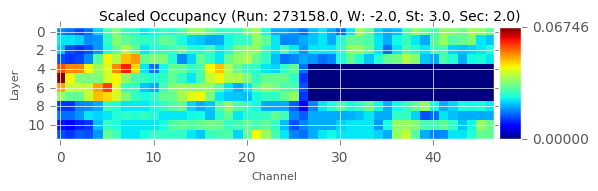

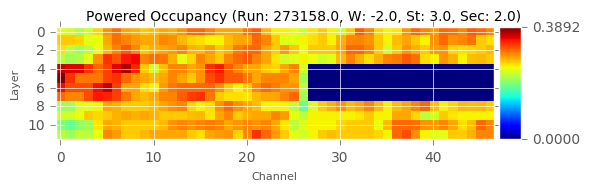

In [16]:
visualize_preprocessing(drift_tubes_chambers[drift_tubes_chambers.score == 4].iloc[0])

#### Chamber with zero non-faulty layers

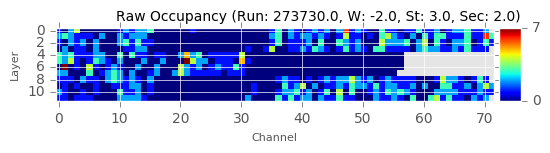

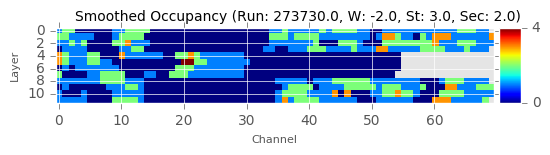

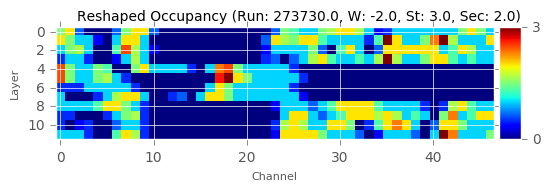

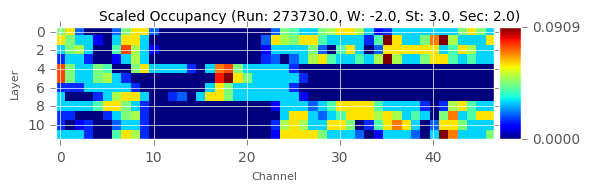

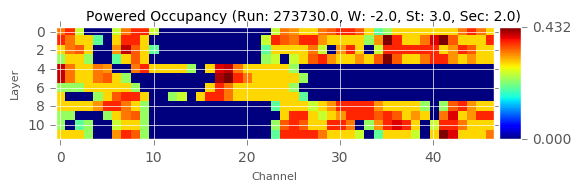

In [17]:
visualize_preprocessing(drift_tubes_chambers[drift_tubes_chambers.score == 12].iloc[0])

## Training the model

Let's define a simple convolutional autoencoder.

In [18]:
_input = Input(shape=(12, 47, 1), name='Input_Image')
x = Conv2D(8, (2, 4), padding='same', name='Convolution_A')(_input)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D((2, 4), padding='same', name='Polling_A')(x)

x = Conv2D(8, (2, 4), padding='same', name='Convolution_B')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D((2, 4), padding='same', name='Polling_B')(x)

x = Conv2D(8, (1, 3), activation='sigmoid', padding='same', name='Convolution_C')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D((1, 3), padding='same', name='Polling_C')(x)

x = Conv2D(2, (1, 3), activation='sigmoid', padding='same', name='Convolution_D')(x)
x = LeakyReLU(alpha=0.1)(x)

encoded_max = MaxPooling2D((3, 1), padding='same', name='encoder_max')(x)
encoded_ave = AveragePooling2D((3, 1), padding='same', name='encoder_ave')(x)

x = UpSampling2D((1, 3))(x)
x = Conv2D(8, (1, 3), padding='same')(x)
x = LeakyReLU(alpha=0.1)(x)

x = UpSampling2D((2, 4))(x)
x = Conv2D(8, (2, 4), padding='same')(x)
x = LeakyReLU(alpha=0.1)(x)

x = UpSampling2D((2, 4))(x)
decoded = Conv2D(1, (1, 2), activation='sigmoid', padding='valid')(x)

encoder_max = Model(_input, encoded_max)
encoder_ave = Model(_input, encoded_ave)
autoencoder = Model(_input, decoded)

### ConvAE Architecture

In [19]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Image (InputLayer)     (None, 12, 47, 1)         0         
_________________________________________________________________
Convolution_A (Conv2D)       (None, 12, 47, 8)         72        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 12, 47, 8)         0         
_________________________________________________________________
Polling_A (MaxPooling2D)     (None, 6, 12, 8)          0         
_________________________________________________________________
Convolution_B (Conv2D)       (None, 6, 12, 8)          520       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 6, 12, 8)          0         
_________________________________________________________________
Polling_B (MaxPooling2D)     (None, 3, 3, 8)           0         
__________

In [20]:
def plot_loss(data, title):
    plt.figure()
    plt.xlabel("Epoch", fontsize=8)
    plt.ylabel("MSE", fontsize=8)
    plt.title(title, fontsize=10)
    plt.plot(data['loss'])
    plt.plot(data['val_loss'])
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show();

Training with 5139 samples.


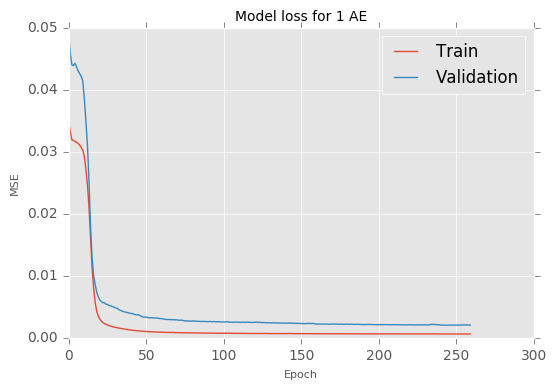

In [21]:
drift_tubes_chambers.loc[:, "score_1_ae"] = np.nan
drift_tubes_chambers.loc[:, "decoded_1_ae"] = np.nan
drift_tubes_chambers.loc[:, "encoded_1_ae_max"] = np.nan
drift_tubes_chambers.loc[:, "encoded_1_ae_ave"] = np.nan

train = drift_tubes_chambers[(drift_tubes_chambers["run"].isin(train_runs)) &
                             (drift_tubes_chambers.station != 4) &
                             (drift_tubes_chambers.score == 0)]
test = drift_tubes_chambers[(drift_tubes_chambers["run"].isin(test_run)) &
                            (drift_tubes_chambers.station != 4)]

print("Training with %s samples." %(len(train)))

x_train = np.array([])
x_test = np.array([])

for _, ch in train.iterrows(): 
    x_train = np.append(x_train, ch["content_powered_scaled"].reshape(12, 47, 1))

for _, ch in test.iterrows(): 
    x_test = np.append(x_test, ch["content_powered_scaled"].reshape(12, 47, 1))

x_train= np.reshape(x_train, (len(train), 12, 47, 1))
x_test= np.reshape(x_test, (len(test), 12, 47, 1))

autoencoder.compile(optimizer='adam', loss='mse')
early_stopper = EarlyStopping(monitor="val_loss", patience=16, verbose=False, mode="auto")
history = autoencoder.fit(x_train, x_train, epochs=1024, validation_split=0.2,
                          batch_size=512, shuffle=True, verbose=False, callbacks=[early_stopper])

plot_loss(history.history, "Model loss for 1 AE")

decoded_imgs = autoencoder.predict(x_test).reshape(len(test), 12, 47)
mse = np.sum(np.sum((x_test.reshape(len(test), 12, 47) - decoded_imgs) ** 2, axis = 1), axis=1)

drift_tubes_chambers.loc[test.index, "score_1_ae"] = mse
drift_tubes_chambers.loc[test.index, "decoded_1_ae"] = pd.DataFrame({"decoded_1_ae": decoded_imgs.tolist()},
                                                                    index=test.index)

drift_tubes_chambers.loc[test.index, "encoded_1_ae_max"] = pd.DataFrame({"encoded_1_ae_max": encoder_max.predict(x_test).reshape(len(test),2).tolist()},
                                                                    index=test.index)
drift_tubes_chambers.loc[train.index, "encoded_1_ae_max"] = pd.DataFrame({"encoded_1_ae_max": encoder_max.predict(x_train).reshape(len(train), 2).tolist()},
                                                                     index=train.index)
drift_tubes_chambers.loc[test.index, "encoded_1_ae_ave"] = pd.DataFrame({"encoded_1_ae_ave": encoder_ave.predict(x_test).reshape(len(test),2).tolist()},
                                                                    index=test.index)
drift_tubes_chambers.loc[train.index, "encoded_1_ae_ave"] = pd.DataFrame({"encoded_1_ae_ave": encoder_ave.predict(x_train).reshape(len(train), 2).tolist()},
                                                                     index=train.index)

Some groups of chamber bahave similarly. We will group them together to train limited amount of models. Wheels are simetrical and sectors do not have big impact on behavior. Moreover station 4 has different occupancy shape, so for now we will discard it. In total we will end up with up to 9 models. We will also exclude all occupancies that are having one or more problematic layers according to CNN model.

Training for wheel 0 and 0 with 1114 samples.


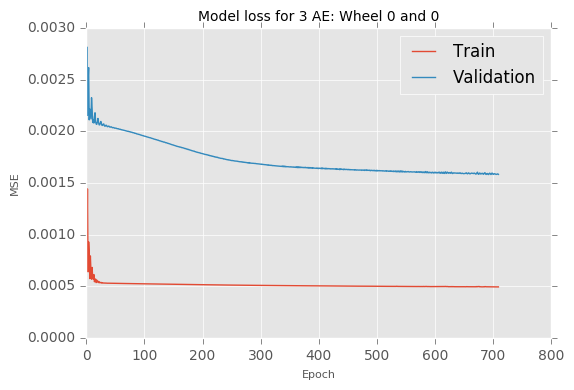

Training for wheel -1 and 1 with 1853 samples.


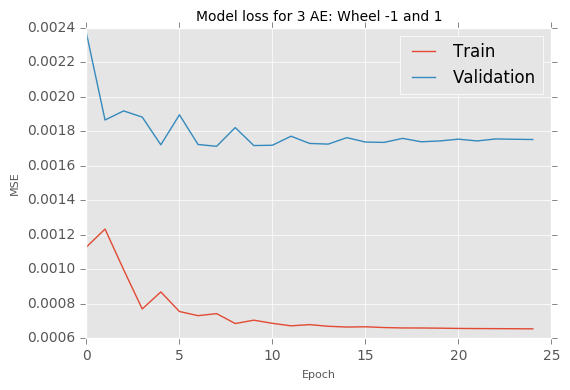

Training for wheel -2 and 2 with 2172 samples.


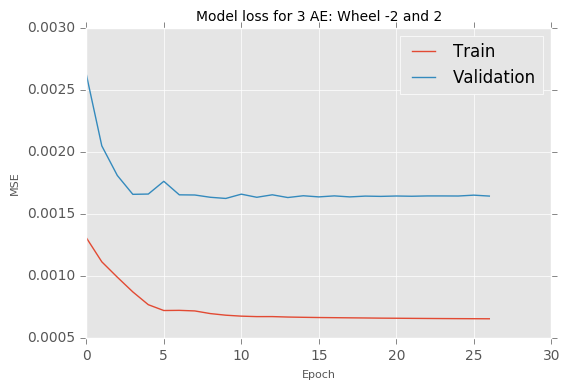

In [22]:
drift_tubes_chambers.loc[:, 'score_3_ae'] = np.nan
drift_tubes_chambers.loc[:, 'decoded_3_ae'] = np.nan
drift_tubes_chambers.loc[:, "encoded_3_ae_max"] = np.nan
drift_tubes_chambers.loc[:, "encoded_3_ae_ave"] = np.nan

for w in range(3):
    train = drift_tubes_chambers[(drift_tubes_chambers["run"].isin(train_runs)) &
                                 (drift_tubes_chambers["wheel"].isin([w, -w])) &
                                 (drift_tubes_chambers.station != 4) &
                                 (drift_tubes_chambers.score == 0)]

    test = drift_tubes_chambers[(drift_tubes_chambers["run"].isin(test_run)) &
                                (drift_tubes_chambers["wheel"].isin([w, -w])) &
                                (drift_tubes_chambers.station != 4)]
    print("Training for wheel %s and %s with %s samples." %(-w, w, len(train)))
    x_train = np.array([])
    x_test = np.array([])

    for _, ch in train.iterrows(): 
        x_train = np.append(x_train, ch["content_powered_scaled"].reshape(12, 47, 1))

    for _, ch in test.iterrows(): 
        x_test = np.append(x_test, ch["content_powered_scaled"].reshape(12, 47, 1))

    x_train= np.reshape(x_train, (len(train), 12, 47, 1))
    x_test= np.reshape(x_test, (len(test), 12, 47, 1))

    autoencoder.compile(optimizer='adam', loss='mse')
    early_stopper = EarlyStopping(monitor="val_loss", patience=16, verbose=False, mode="auto")
    history = autoencoder.fit(x_train, x_train, epochs=1024, validation_split=0.2,
                              batch_size=512, shuffle=True, verbose=False, callbacks=[early_stopper])

    plot_loss(history.history, ("Model loss for 3 AE: Wheel %s and %s" % (-w, w)))

    decoded_imgs = autoencoder.predict(x_test).reshape(len(test), 12, 47)
    mse = np.sum(np.sum((x_test.reshape(len(test), 12, 47) - decoded_imgs) ** 2, axis = 1), axis=1)
    drift_tubes_chambers.loc[test.index, 'score_3_ae'] = mse

    drift_tubes_chambers.loc[test.index, 'decoded_3_ae'] = pd.DataFrame({"decoded_3_ae": decoded_imgs.tolist()},
                                                                           index=test.index)
    drift_tubes_chambers.loc[test.index, "encoded_3_ae_max"] = pd.DataFrame({"encoded_3_ae_max": encoder_max.predict(x_test).reshape(len(test),2).tolist()},
                                                                    index=test.index)
    drift_tubes_chambers.loc[train.index, "encoded_3_ae_max"] = pd.DataFrame({"encoded_3_ae_max": encoder_max.predict(x_train).reshape(len(train), 2).tolist()},
                                                                         index=train.index)
    drift_tubes_chambers.loc[test.index, "encoded_3_ae_ave"] = pd.DataFrame({"encoded_3_ae_ave": encoder_ave.predict(x_test).reshape(len(test),2).tolist()},
                                                                        index=test.index)
    drift_tubes_chambers.loc[train.index, "encoded_3_ae_ave"] = pd.DataFrame({"encoded_3_ae_ave": encoder_ave.predict(x_train).reshape(len(train), 2).tolist()},
                                                                         index=train.index)

Training for wheel 0 and 0 and station 1 with 405 samples.


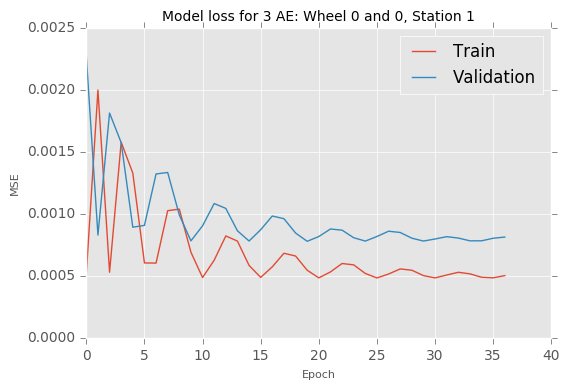

Training for wheel 0 and 0 and station 2 with 355 samples.


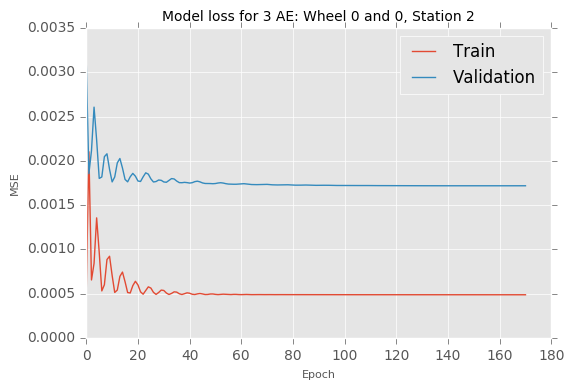

Training for wheel 0 and 0 and station 3 with 354 samples.


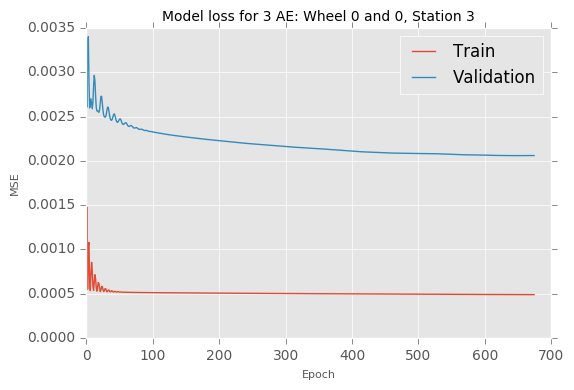

Training for wheel -1 and 1 and station 1 with 697 samples.


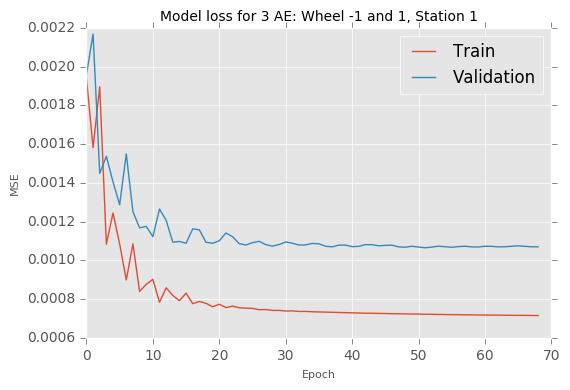

Training for wheel -1 and 1 and station 2 with 615 samples.


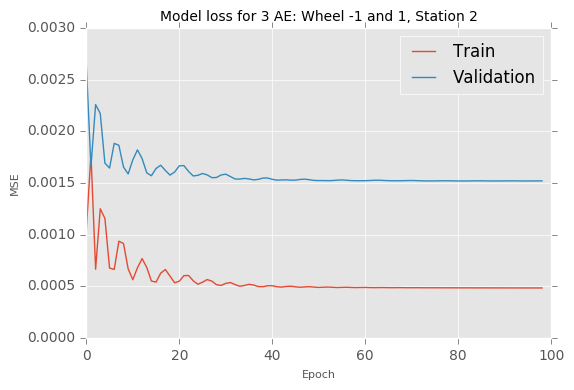

Training for wheel -1 and 1 and station 3 with 541 samples.


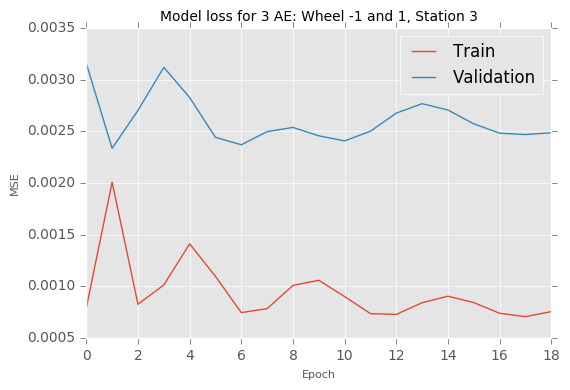

Training for wheel -2 and 2 and station 1 with 714 samples.


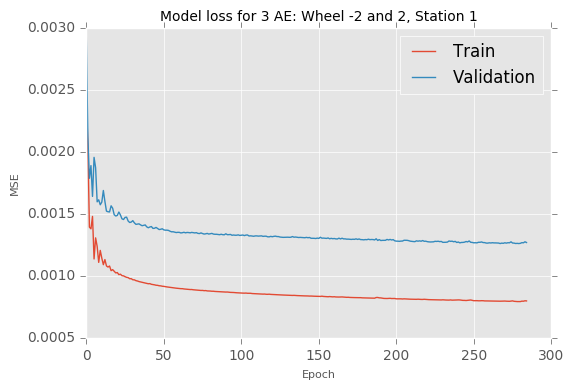

Training for wheel -2 and 2 and station 2 with 739 samples.


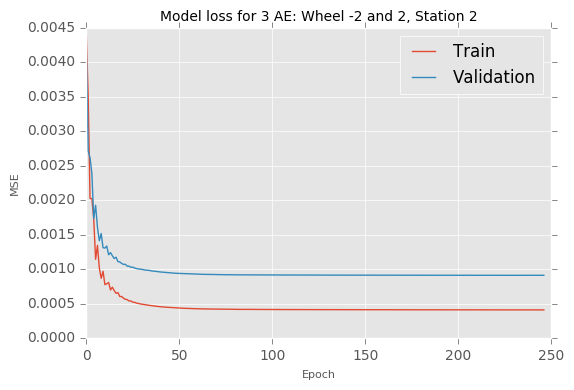

Training for wheel -2 and 2 and station 3 with 719 samples.


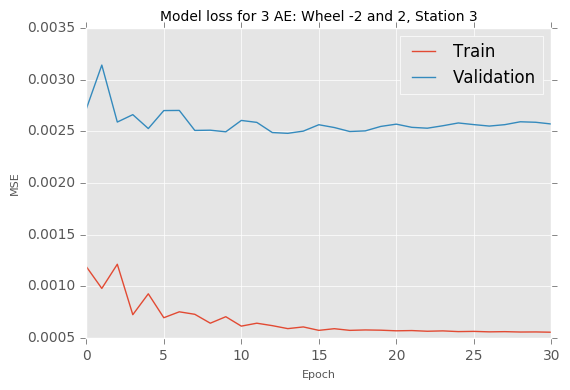

In [23]:
drift_tubes_chambers.loc[:, 'score_9_ae'] = np.nan
drift_tubes_chambers.loc[:, 'decoded_9_ae'] = np.nan
drift_tubes_chambers.loc[:, 'encoded_9_ae_ave'] = np.nan
drift_tubes_chambers.loc[:, 'encoded_9_ae_max'] = np.nan
for w in range(3):
    for st in range(1, 4):
        train = drift_tubes_chambers[(drift_tubes_chambers["run"].isin(train_runs)) &
                                     (drift_tubes_chambers["wheel"].isin([w, -w])) &
                                     (drift_tubes_chambers.station == st) &
                                     (drift_tubes_chambers.score == 0)]

        test = drift_tubes_chambers[(drift_tubes_chambers["run"].isin(test_run)) &
                                    (drift_tubes_chambers["wheel"].isin([w, -w])) &
                                    (drift_tubes_chambers.station == st)]

        print("Training for wheel %s and %s and station %s with %s samples." %(-w, w, st, len(train)))

        x_train = np.array([])
        x_test = np.array([])

        for _, ch in train.iterrows(): 
            x_train = np.append(x_train, ch["content_powered_scaled"].reshape(12, 47, 1))

        for _, ch in test.iterrows(): 
            x_test = np.append(x_test, ch["content_powered_scaled"].reshape(12, 47, 1))

        x_train= np.reshape(x_train, (len(train), 12, 47, 1))
        x_test= np.reshape(x_test, (len(test), 12, 47, 1))

        early_stopper = EarlyStopping(monitor="val_loss", patience=16, verbose=False, mode="auto")
        autoencoder.compile(optimizer='adam', loss='mse')
        history = autoencoder.fit(x_train, x_train, epochs=1024, validation_split=0.2,
                                  batch_size=512, shuffle=True, verbose=False, callbacks=[early_stopper])

        plot_loss(history.history, ("Model loss for 3 AE: Wheel %s and %s, Station %s" % (-w, w, st)))            
        decoded_imgs = autoencoder.predict(x_test).reshape(len(test), 12, 47)
        mse = np.sum(np.sum((x_test.reshape(len(test), 12, 47) - decoded_imgs) ** 2, axis = 1), axis=1)
        drift_tubes_chambers.loc[test.index, 'score_9_ae'] = mse

        drift_tubes_chambers.loc[test.index, 'decoded_9_ae'] = pd.DataFrame({"decoded_9_ae": decoded_imgs.tolist()},
                                                                       index=test.index)
        
        drift_tubes_chambers.loc[test.index, 'decoded_9_ae'] = pd.DataFrame({"decoded_9_ae": decoded_imgs.tolist()},
                                                                               index=test.index)
        drift_tubes_chambers.loc[test.index, "encoded_9_ae_max"] = pd.DataFrame({"encoded_9_ae_max": encoder_max.predict(x_test).reshape(len(test),2).tolist()},
                                                                        index=test.index)
        drift_tubes_chambers.loc[train.index, "encoded_9_ae_max"] = pd.DataFrame({"encoded_9_ae_max": encoder_max.predict(x_train).reshape(len(train), 2).tolist()},
                                                                             index=train.index)
        drift_tubes_chambers.loc[test.index, "encoded_9_ae_ave"] = pd.DataFrame({"encoded_9_ae_ave": encoder_ave.predict(x_test).reshape(len(test),2).tolist()},
                                                                            index=test.index)
        drift_tubes_chambers.loc[train.index, "encoded_9_ae_ave"] = pd.DataFrame({"encoded_9_ae_ave": encoder_ave.predict(x_train).reshape(len(train), 2).tolist()},
                                                                             index=train.index)

### Data snooping

Let's take a look at some of the results.

In [24]:
def original_vs_reconstructed(show):
    index = "(Run: %s, W: %s, St: %s, Sec: %s" % (show.run, show.wheel, show.station, show.sector)
    title = "Original Sample %s" % index
    plot_occupancy_hitmap(show.content_powered_scaled, title)
    title = "Reconstruction with 9 AE %s" % index
    plot_occupancy_hitmap(show.decoded_9_ae, title)
    title = "Reconstruction with 3 AE %s" % index
    plot_occupancy_hitmap(show.decoded_3_ae, title)
    title = "Reconstruction with 1 AE %s" % index
    plot_occupancy_hitmap(show.decoded_1_ae, title)

#### The best reconstruction

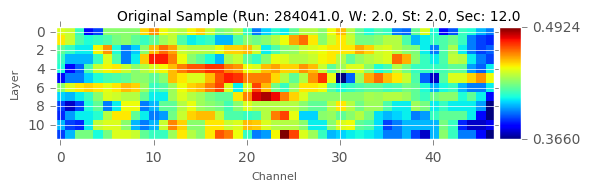

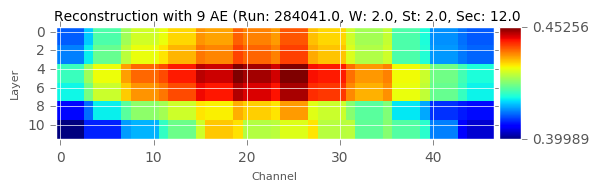

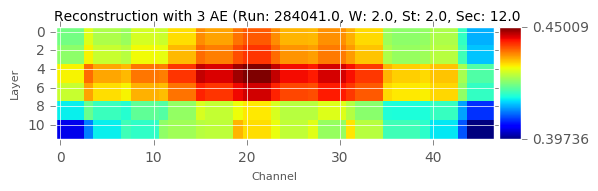

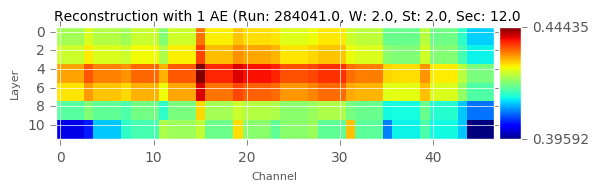

In [25]:
original_vs_reconstructed(drift_tubes_chambers.sort_values('score_1_ae', ascending=1).iloc[0])

#### The worst reconstruction

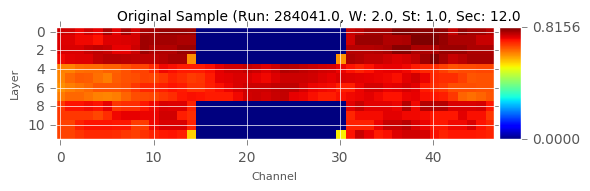

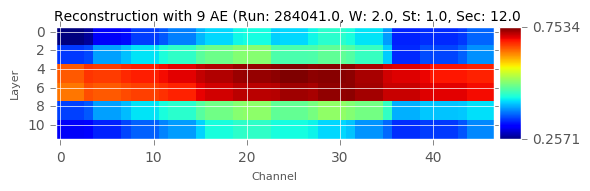

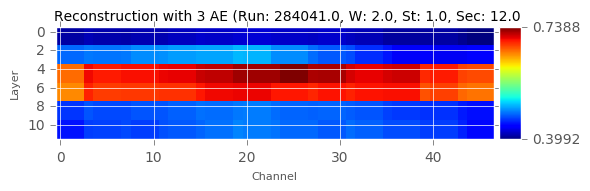

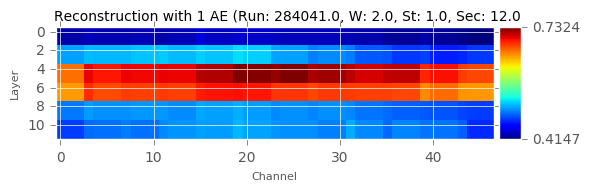

In [26]:
original_vs_reconstructed(drift_tubes_chambers.sort_values('score_1_ae', ascending=0).iloc[0])

#### Best reconstruction for a chamber having at least one superlayer problem:

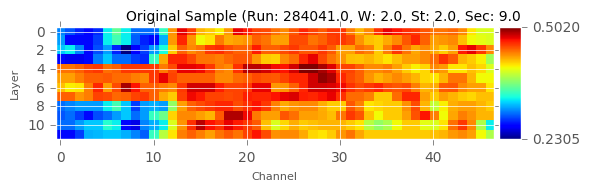

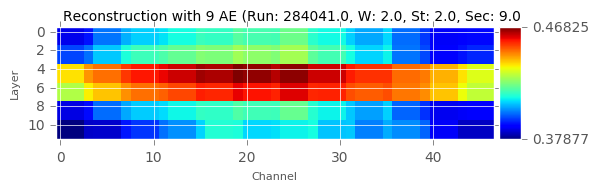

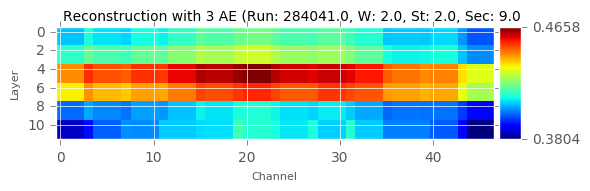

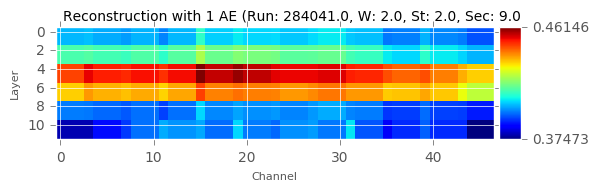

In [27]:
original_vs_reconstructed(drift_tubes_chambers[drift_tubes_chambers.score > 4].sort_values('score_1_ae', ascending=1).iloc[0])

#### Worst reconstruction for a chamber without problems: 

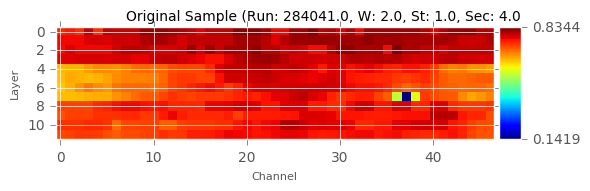

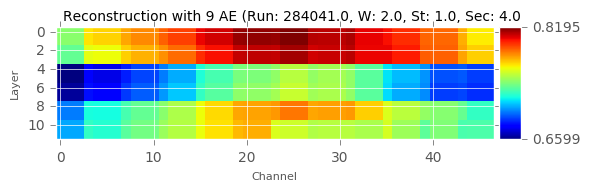

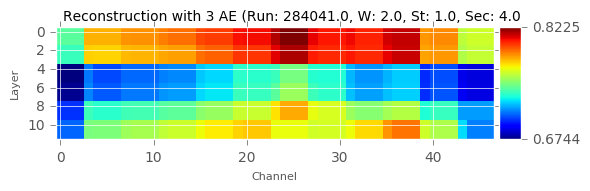

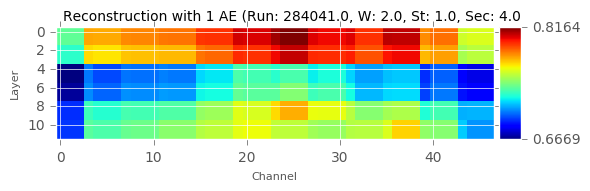

In [28]:
original_vs_reconstructed(drift_tubes_chambers[drift_tubes_chambers.score == 0].sort_values('score_1_ae', ascending=0).iloc[0])

### Evaluation

In this model we hoped to catch all the chambers that were considered problematic by CNN plus some others that the classifier did see as good since the additional information about the numerical relations between chambers was removed. Hence in a ROC Curve we are not as interested as the AUC but the fall-out rate for sensitivity equal to 1. The smaller fall-out the better since we are accounting on small number of faults unrelated to dead region.

/usr/lib64/python2.7/site-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


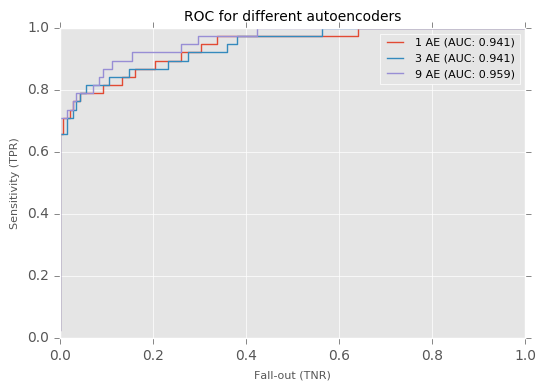

In [29]:
from sklearn.metrics import roc_curve, auc

evaluation = drift_tubes_chambers[(drift_tubes_chambers["run"].isin(test_run)) &
                                  (drift_tubes_chambers["station"] != 4)]
evaluation.score = (evaluation.score > 0) + 0

for ae in [1, 3, 9]:
    column = "score_%s_ae" % ae
    false_positive_rate, true_positive_rate, _ = roc_curve(evaluation["score"], evaluation[column])
    title = "%s AE (AUC: %s)" % (ae, round(auc(false_positive_rate, true_positive_rate), 3))
    plt.plot(false_positive_rate, true_positive_rate, label=title)

plt.title("ROC for different autoencoders", fontsize=10)
plt.ylabel("Sensitivity (TPR)", fontsize=8)
plt.xlabel("Fall-out (TNR)", fontsize=8)
plt.legend(fontsize=8)

plt.show();

Distribution of error for different autoencoders in the test set. Include all chambers that have less faulty layeres than FAULT.

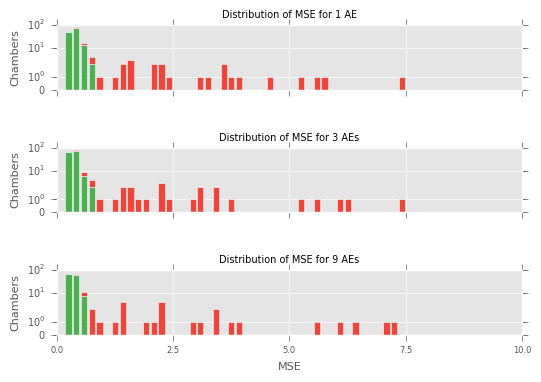

In [30]:
FAULTS = 12

evaluation = drift_tubes_chambers[(drift_tubes_chambers["run"].isin(test_run)) &
                                  (drift_tubes_chambers["station"] != 4) &
                                  (drift_tubes_chambers["score"] <= FAULTS)]

binBoundaries = np.linspace(0, max(evaluation.score_1_ae.values), 300)

import matplotlib.ticker as mticker

plt.figure()

ax1 = plt.subplot(3, 1, 1)
ax1.hist([evaluation[evaluation.score == 0].score_1_ae.values,
          evaluation[evaluation.score > 0].score_1_ae.values],
         bins=binBoundaries, stacked=True, color=['#4CAF50', '#F44336'])
ax1.set_title("Distribution of MSE for 1 AE", fontsize=7)
ax1.set_xlim([0,10])

ax2 = plt.subplot(3, 1, 2, sharex=ax1, sharey=ax1)
ax2.hist([evaluation[evaluation.score == 0].score_3_ae.values, 
          evaluation[evaluation.score > 0].score_3_ae.values],
         bins=binBoundaries, stacked=True, color=['#4CAF50', '#F44336'])
ax2.set_title("Distribution of MSE for 3 AEs", fontsize=7)
ax2.set_xlim([0,10])

ax3 = plt.subplot(3, 1, 3, sharex=ax1, sharey=ax1)
ax3.hist([evaluation[evaluation.score == 0].score_9_ae.values,
          evaluation[evaluation.score > 0].score_9_ae.values],
         bins=binBoundaries, stacked=True, color=['#4CAF50', '#F44336'])
ax3.set_title("Distribution of MSE for 9 AEs", fontsize=7)
ax3.set_xlim([0,10])

ax3.xaxis.set_major_locator(mticker.MaxNLocator(4))
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax3.get_xticklabels(), fontsize=6)

plt.setp(ax1.get_yticklabels(), fontsize=7)
plt.setp(ax2.get_yticklabels(), fontsize=7)
plt.setp(ax3.get_yticklabels(), fontsize=7)

plt.xlabel("MSE", fontsize=8)
ax1.set_ylabel("Chambers", fontsize=8)
ax2.set_ylabel("Chambers", fontsize=8)
ax3.set_ylabel("Chambers", fontsize=8)
plt.yscale("symlog")
plt.subplots_adjust(hspace=0.9)
plt.show()

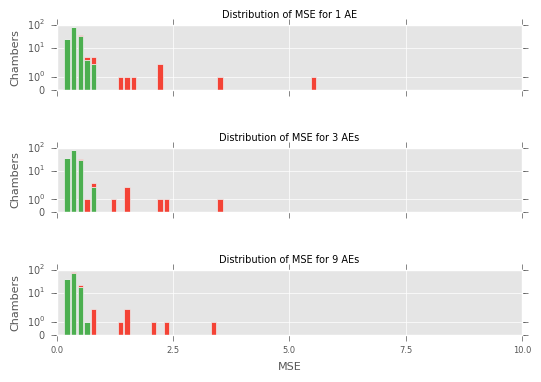

In [31]:
FAULTS = 1

evaluation = drift_tubes_chambers[(drift_tubes_chambers["run"].isin(test_run)) &
                                  (drift_tubes_chambers["station"] != 4) &
                                  (drift_tubes_chambers["score"] <= FAULTS)]

binBoundaries = np.linspace(0, max(evaluation.score_1_ae.values), 40)

import matplotlib.ticker as mticker

plt.figure()

ax1 = plt.subplot(3, 1, 1)
ax1.hist([evaluation[evaluation.score == 0].score_1_ae.values,
          evaluation[evaluation.score > 0].score_1_ae.values],
         bins=binBoundaries, stacked=True, color=['#4CAF50', '#F44336'])
ax1.set_title("Distribution of MSE for 1 AE", fontsize=7)
ax1.set_xlim([0,10])

ax2 = plt.subplot(3, 1, 2, sharex=ax1, sharey=ax1)
ax2.hist([evaluation[evaluation.score == 0].score_3_ae.values, 
          evaluation[evaluation.score > 0].score_3_ae.values],
         bins=binBoundaries, stacked=True, color=['#4CAF50', '#F44336'])
ax2.set_title("Distribution of MSE for 3 AEs", fontsize=7)
ax2.set_xlim([0,10])

ax3 = plt.subplot(3, 1, 3, sharex=ax1, sharey=ax1)
ax3.hist([evaluation[evaluation.score == 0].score_9_ae.values,
          evaluation[evaluation.score > 0].score_9_ae.values],
         bins=binBoundaries, stacked=True, color=['#4CAF50', '#F44336'])
ax3.set_title("Distribution of MSE for 9 AEs", fontsize=7)
ax3.set_xlim([0,10])

ax3.xaxis.set_major_locator(mticker.MaxNLocator(4))
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax3.get_xticklabels(), fontsize=6)

plt.setp(ax1.get_yticklabels(), fontsize=7)
plt.setp(ax2.get_yticklabels(), fontsize=7)
plt.setp(ax3.get_yticklabels(), fontsize=7)

plt.xlabel("MSE", fontsize=8)
ax1.set_ylabel("Chambers", fontsize=8)
ax2.set_ylabel("Chambers", fontsize=8)
ax3.set_ylabel("Chambers", fontsize=8)
plt.yscale("symlog")
plt.subplots_adjust(hspace=0.9)
plt.show()

Dimensionality reduction with AE:

In [32]:
def dimentionality_reduction(color_by, encoder):
    for ae in [1, 3, 9]:
        column = "encoded_%s_ae_%s" % (ae, encoder)
        evaluation = drift_tubes_chambers[drift_tubes_chambers[column].notnull()] # filter here
        encoded = np.array([_ for _ in evaluation[column].values])
        plt.scatter(encoded[:, 0], encoded[:, 1], c=[_ for _ in evaluation[color_by].values],
                    alpha=0.3, s=20, marker='s')
        if color_by == "station":
            tick = range(1, 4)
        else:
            tick = range(-2, 3)
        cbar = plt.colorbar(ticks=tick)
        cbar.ax.set_yticklabels([str(_) for _ in tick])
        plt.title(("For %s AE" % ae), fontsize = 8)
        plt.show()

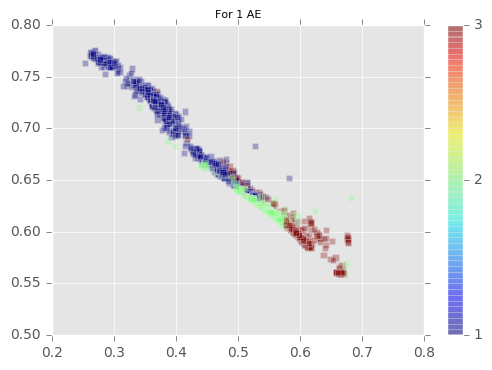

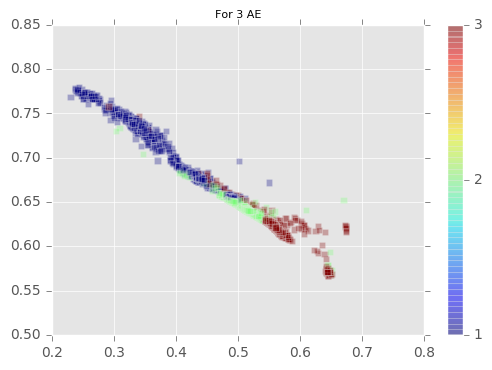

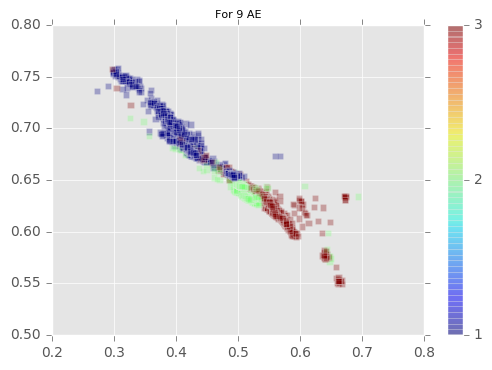

In [33]:
dimentionality_reduction("station", "max")

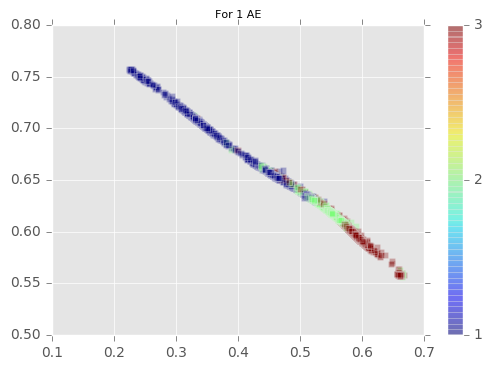

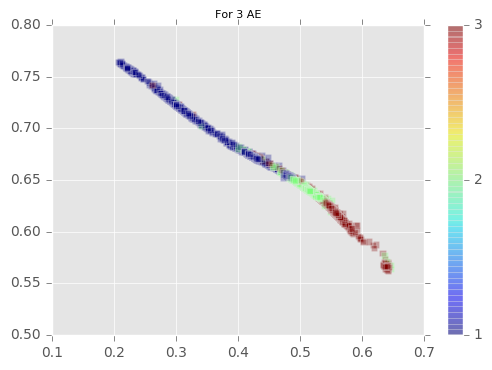

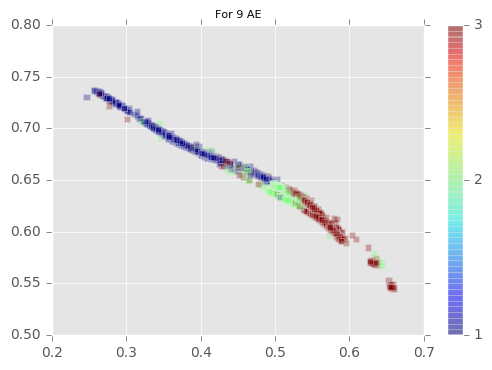

In [34]:
dimentionality_reduction("station", "ave")

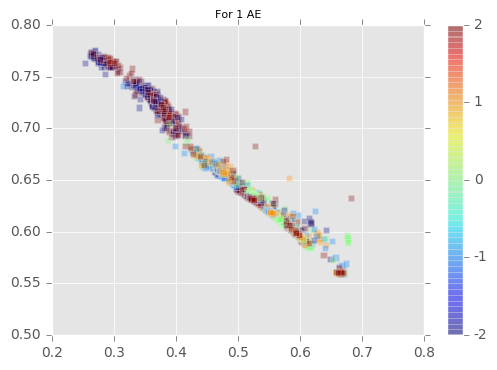

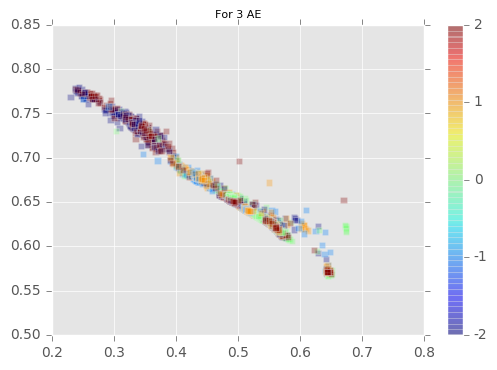

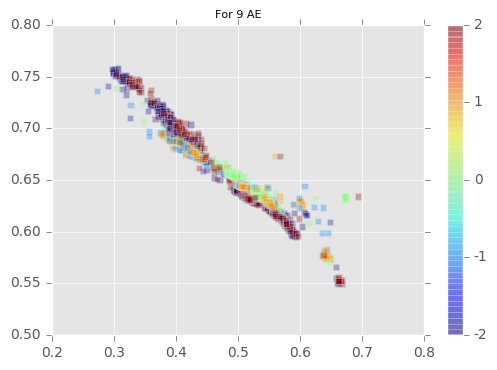

In [35]:
dimentionality_reduction("wheel", "max")

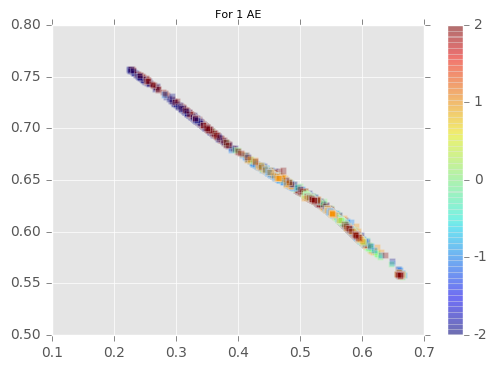

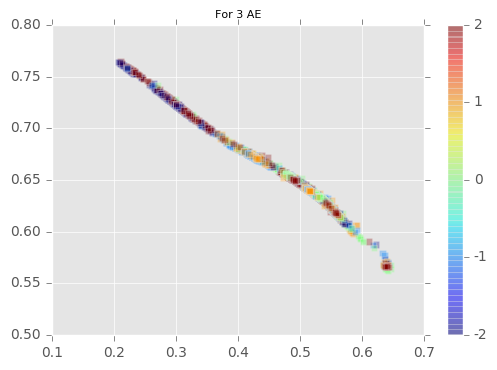

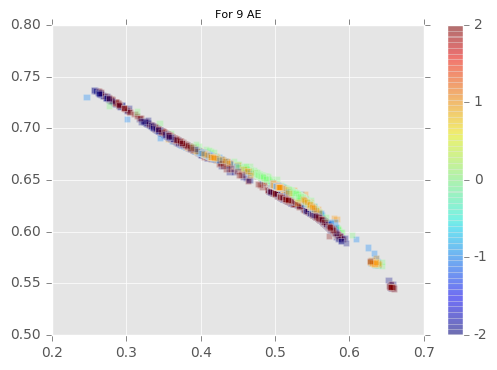

In [36]:
dimentionality_reduction("wheel", "ave")